In [2]:
import copy
import itertools
from pprint import pprint

import luigi
import dill
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
sns.set()
sns.set_context("talk")
mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams['figure.dpi'] = 140
mpl.rcParams['savefig.dpi'] = 160

from luigi_utils.helpers import load_completed_CCCs_into_dataframe
from empirical_privacy.row_distributed_svd import gen_SVD_CCCs_for_multiple_docs, \
svd_dataset_settings
from dataset_utils.recsys_datasets import get_ml1m_user
from dataset_utils.text_datasets import get_twenty_doc

In [3]:
CCCs = []
datasets = [
    #'20NG', 
   'ml-1m'
]
part_fractions = [
    0.01,
    0.1
]

for dataset, pf in itertools.product(datasets, part_fractions):
    ds = svd_dataset_settings(dataset_name=dataset, part_fraction=pf)
    _CCCs = gen_SVD_CCCs_for_multiple_docs(n_max=2048,
                                          validation_set_size=512,
                                          n_docs=5,
                                          n_trials_per_training_set_size=30,
                                          dataset_settings=ds)
    CCCs += _CCCs

In [4]:
DF = load_completed_CCCs_into_dataframe(CCCs)
n_docs = DF.doc_ind.nunique()
cp = sns.color_palette('hls', n_docs)
print(DF.columns)
print(DF.shape)

Index(['SVD_k', 'SVD_type', 'classifier_accuracy', 'dataset_name', 'doc_ind',
       'n_max', 'n_trials_per_training_set_size', 'part_fraction',
       'training_set_size', 'trial', 'validation_set_size'],
      dtype='object')
(2700, 11)


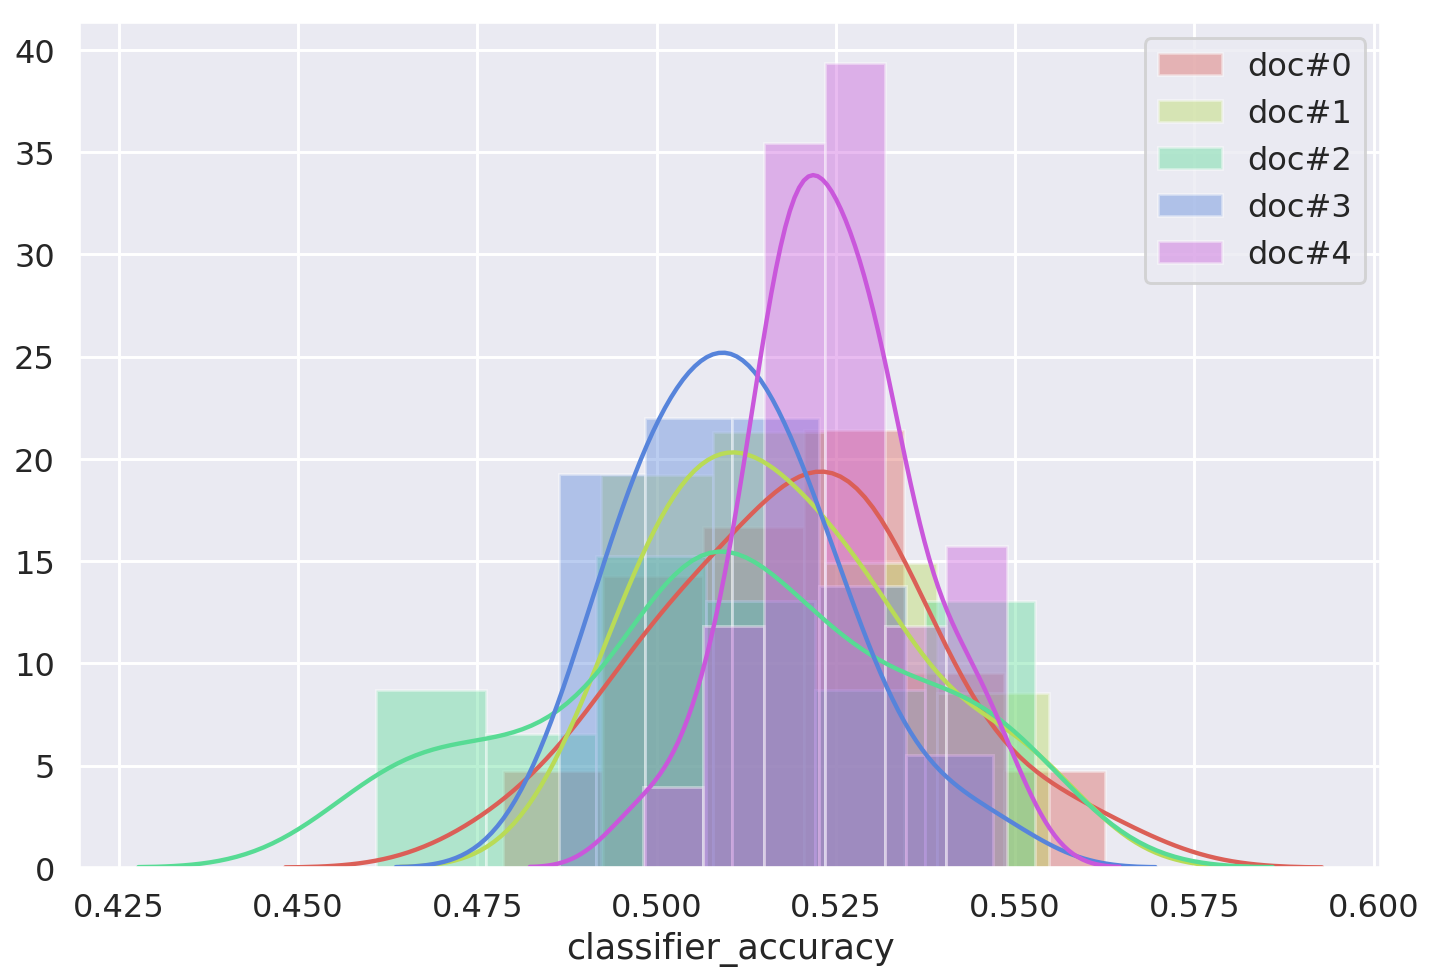

In [11]:
for (sgn, sdf) in DF[(DF.training_set_size==2048) & (DF.part_fraction==0.1)]\
    .groupby(['doc_ind', 'training_set_size']):
    sns.distplot(sdf.classifier_accuracy, label=f'doc#{sgn[0]}', color=cp[sgn[0]])
plt.legend()

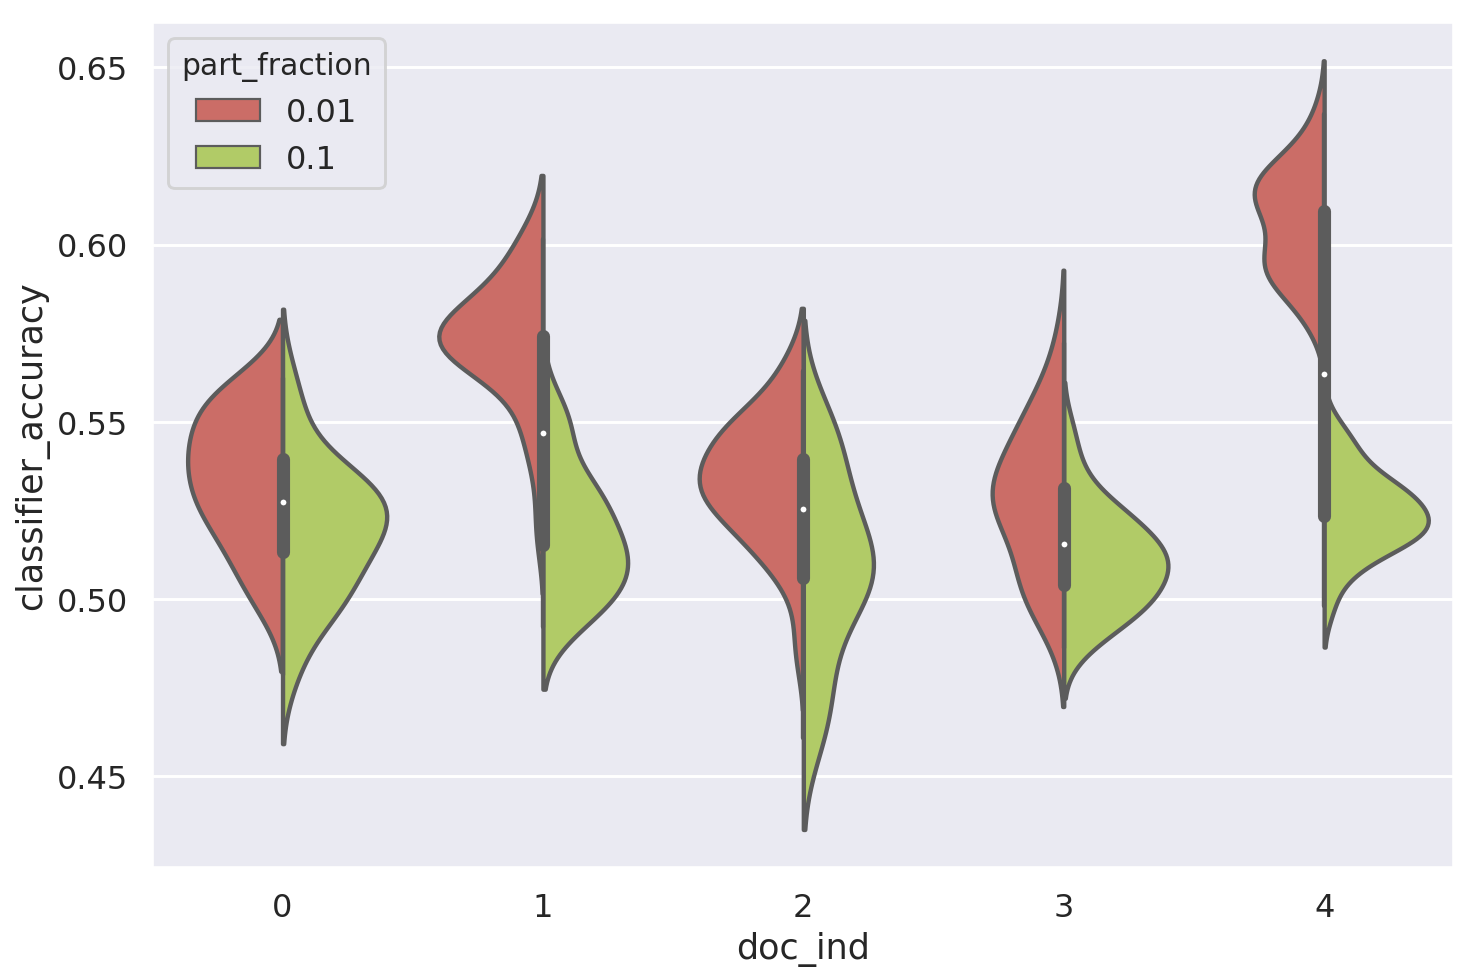

In [12]:
SDF = DF[DF.training_set_size==2048]
sns.violinplot(x='doc_ind',
               y='classifier_accuracy', 
               hue="part_fraction",
               data=SDF,
              split=True,  # only has an effect with hue enabled
               palette=cp
              )

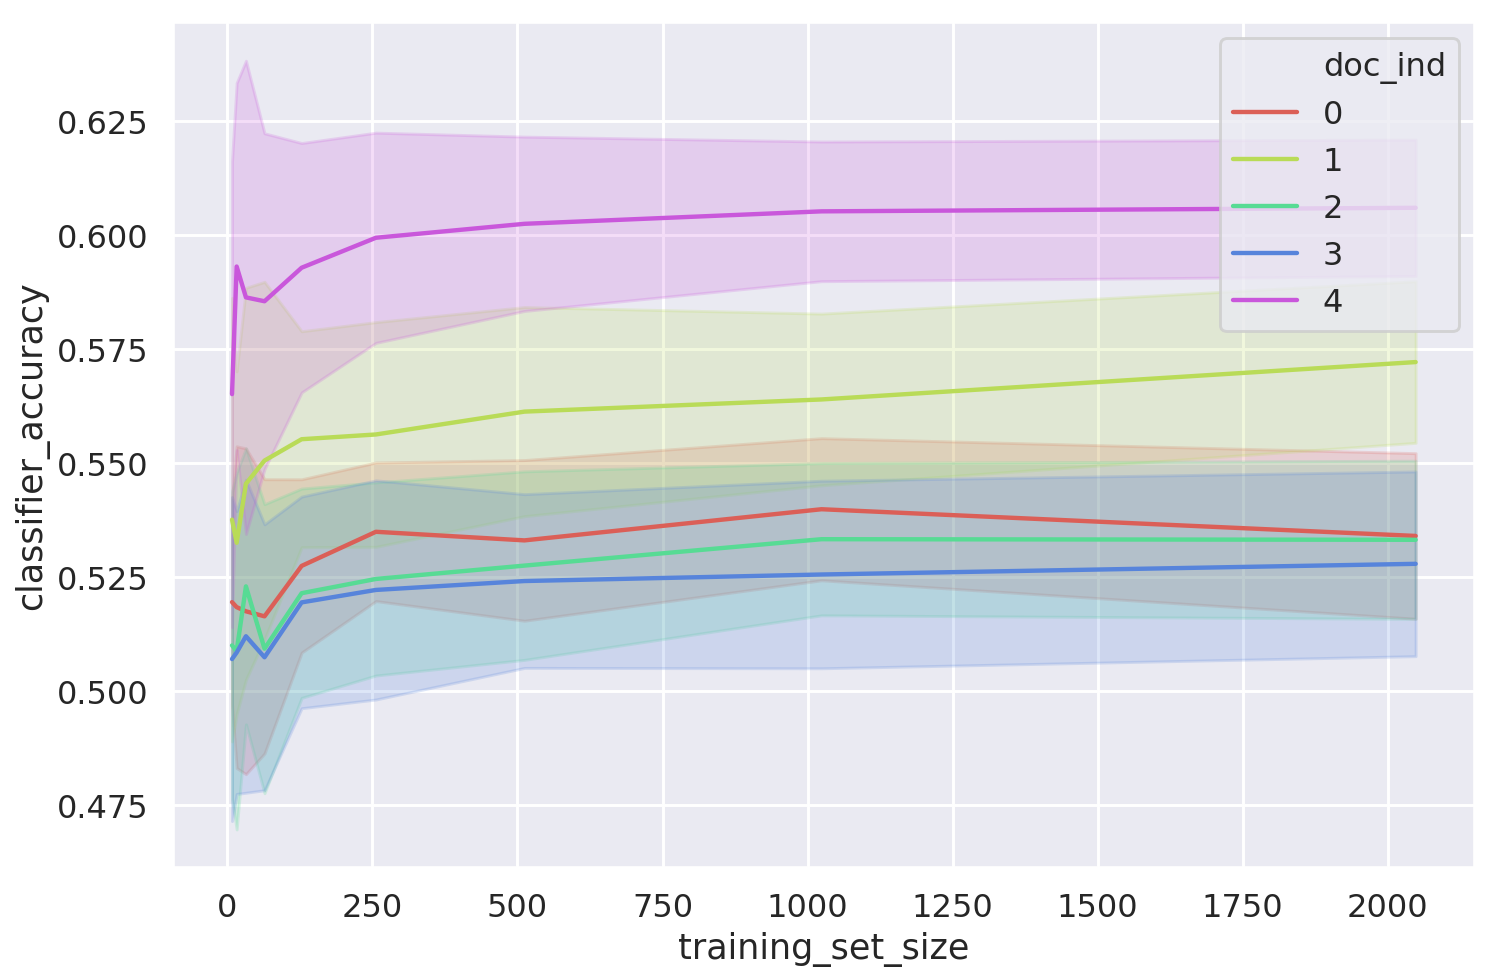

In [13]:
handle = sns.lineplot(
    data=DF[DF.part_fraction==0.01],
    x='training_set_size',
    y='classifier_accuracy',
    hue='doc_ind',
    legend='full',
    palette=cp,
    ci='sd',
    err_style='band'
)

### Investigating a particular user


In [16]:
users={}
for i in range(5):
    users[i] = get_ml1m_user(i)

/emp_priv/src/dataset_utils/recsys_datasets.py:70: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  header=None,
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:1579: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  infer_datetime_format=infer_datetime_format)
/emp_priv/src/dataset_utils/recsys_datasets.py:78: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  header=None
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 


###### User #3 has the lowest accuracy for the classifier

In [18]:
users[3]['User']

,UserID,Gender,Age,Occupation,Zip-code
3,4,M,45,7,02460


In [19]:
users[3]['Ratings']

,MovieID,Title,Genres,rating
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,5
476,480,Jurassic Park (1993),Action|Adventure|Sci-Fi,4
1023,1036,Die Hard (1988),Action|Thriller,4
1178,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,2
1180,1198,Raiders of the Lost Ark (1981),Action|Adventure,5
1220,1240,"Terminator, The (1984)",Action|Sci-Fi|Thriller,5
1366,1387,Jaws (1975),Action|Horror,5
1885,1954,Rocky (1976),Action|Drama,5
1959,2028,Saving Private Ryan (1998),Action|Drama|War,5
2297,2366,King Kong (1933),Action|Adventure|Horror,4


##### User #4 has the highest accuracy

In [20]:
users[4]['User']

,UserID,Gender,Age,Occupation,Zip-code
4,5,M,25,20,55455


In [21]:
users[4]['Ratings']

,MovieID,Title,Genres,rating
5,6,Heat (1995),Action|Crime|Thriller,2
15,16,Casino (1995),Drama|Thriller,3
23,24,Powder (1995),Drama|Sci-Fi,1
33,34,Babe (1995),Children's|Comedy|Drama,4
35,36,Dead Man Walking (1995),Drama,3
40,41,Richard III (1995),Drama|War,4
51,52,Mighty Aphrodite (1995),Comedy,2
148,150,Apollo 13 (1995),Drama,2
160,162,Crumb (1994),Documentary,4
192,194,Smoke (1995),Drama,3


In [25]:
for u in users:
    print(f"{u} rated {users[u]['Ratings'].shape[0]} movies")

0 rated 41  movies
1 rated 89  movies
2 rated 34  movies
3 rated 16  movies
4 rated 144  movies


So users who rate more than the average movies are easier to identify.

## How about the 20NG text dataset?

For the 20NG text dataset rows are normalized to sum to 1, i.e. each document has the same 'weight' so we shouldn't see one document being easier to detect because it has a larger sum.

In [8]:
n_docs=5
trials=8
pf=[0.01,0.1,0.3]
n_max=2048
dname='20NG'

CCCs = []
for _pf in pf:
    ds = svd_dataset_settings(dataset_name=dname, part_fraction=_pf)
    _CCCs = gen_SVD_CCCs_for_multiple_docs(n_max=n_max,
                                          validation_set_size=512,
                                          n_docs=n_docs,
                                          n_trials_per_training_set_size=trials,
                                          dataset_settings=ds)
    CCCs += _CCCs
DF = load_completed_CCCs_into_dataframe(CCCs)
n_docs = DF.doc_ind.nunique()
cp = sns.color_palette('hls', n_docs)
print(DF.columns)
print(DF.shape)

Index(['SVD_k', 'SVD_type', 'classifier_accuracy', 'dataset_name', 'doc_ind',
       'n_max', 'n_trials_per_training_set_size', 'part_fraction',
       'training_set_size', 'trial', 'validation_set_size'],
      dtype='object')
(1080, 11)


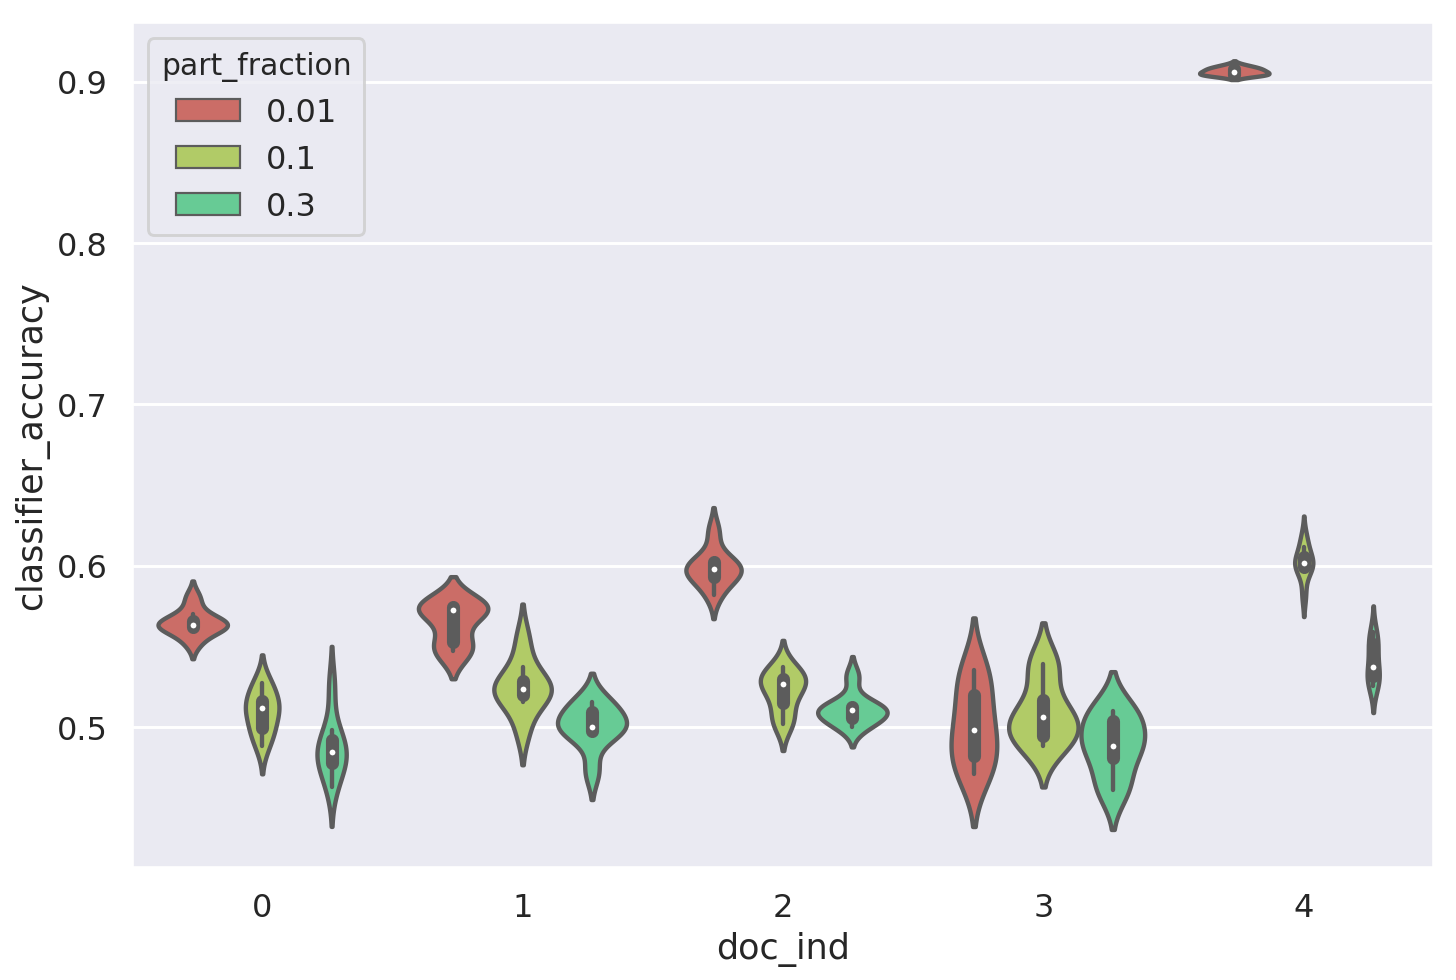

In [9]:
SDF = DF[DF.training_set_size==n_max]
sns.violinplot(x='doc_ind',
               y='classifier_accuracy', 
               hue="part_fraction",
               data=SDF,
              #split=True,  # only has an effect with hue enabled
               palette=cp
              )

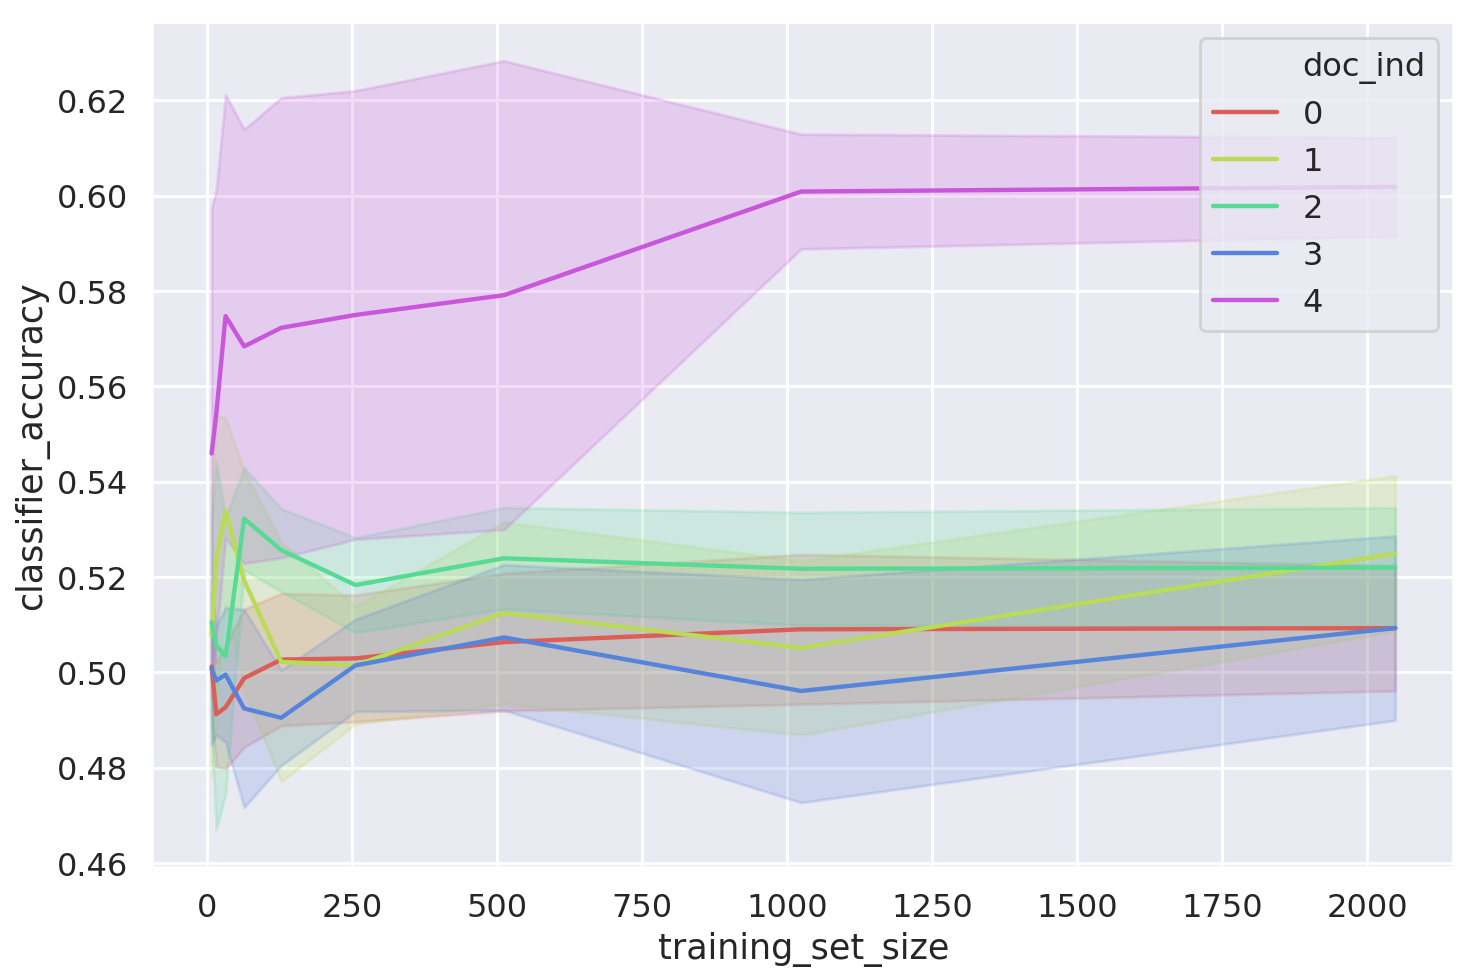

In [10]:
handle = sns.lineplot(
    data=DF[DF.part_fraction==0.1],
    x='training_set_size',
    y='classifier_accuracy',
    hue='doc_ind',
    legend='full',
    palette=cp,
    ci='sd',
    err_style='band'
)

Doc #4 is much easier to identify than doc #3, why is that? Let's look at those documents.

### Doc#4

In [11]:
doc=get_twenty_doc(4)
pprint(doc)

{'text': 'Well, I will have to change the scoring on my playoff pool.  '
         'Unfortunately\n'
         "I don't have time right now, but I will certainly post the new "
         'scoring\n'
         "rules by tomorrow.  Does it matter?  No, you'll enter anyway!!!  "
         'Good!\n'
         '\n'
         '--\n'
         "    Keith Keller\t\t\t\tLET'S GO RANGERS!!!!!\n"
         "\t\t\t\t\t\tLET'S GO QUAKERS!!!!!\n"
         '\tkkeller@mail.sas.upenn.edu\t\tIVY LEAGUE CHAMPS!!!!',
 'tfidf': 2.9258121990599166,
 'words': [(0.39341719025139776, 'let'),
           (0.33871562029001295, 'rules'),
           (0.31784036452251069, 'league'),
           (0.30154936285720241, 'unfortunately'),
           (0.26007809947584859, 'certainly'),
           (0.25637378592827909, 'matter'),
           (0.24859612427892749, 'change'),
           (0.2222836402134164, 'post'),
           (0.20922313941300047, 'mail'),
           (0.19073078768748242, 'll'),
           (0.18700408414183811, 'edu')

### Doc #3

In [13]:
doc=get_twenty_doc(0)
pprint(doc)

{'text': "Well i'm not sure about the story nad it did seem biased. What\n"
         'I disagree with is your statement that the U.S. Media is out to\n'
         'ruin Israels reputation. That is rediculous. The U.S. media is\n'
         'the most pro-israeli media in the world. Having lived in Europe\n'
         'I realize that incidences such as the one described in the\n'
         'letter have occured. The U.S. media as a whole seem to try to\n'
         'ignore them. The U.S. is subsidizing Israels existance and the\n'
         'Europeans are not (at least not to the same degree). So I think\n'
         'that might be a reason they report more clearly on the\n'
         'atrocities.\n'
         '\tWhat is a shame is that in Austria, daily reports of\n'
         'the inhuman acts commited by Israeli soldiers and the blessing\n'
         'received from the Government makes some of the Holocaust guilt\n'
         'go away. After all, look how the Jews are treating other races\n'
     